In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
#import seaborn as sns

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, UpSampling2D, Input, ZeroPadding2D, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
#import tensorflow_probability as tfp

from scipy import stats
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import mse, binary_crossentropy,mean_absolute_error ,huber
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import unit_norm, max_norm
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#import nibabel as nib
import scipy as sp
import scipy.ndimage
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import MDS

2023-04-02 17:58:04.333769: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.1


# LOADING THE DATASET

In [2]:
hf=h5py.File("../data/img_p+Fe_MST+SST.hdf5", 'r')
hf.keys()

<KeysViewHDF5 ['MST', 'SST']>

In [3]:
def aux_features(file):
    
    aux_vars = pd.read_csv(file).drop(columns=['Unnamed: 0'])
    scaler = StandardScaler()
    aux_vars = scaler.fit_transform(aux_vars)
    
    return aux_vars

# SST (48X48) and MST(112X112) IMAGES

In [4]:
data_MST = hf['MST']
data_SST = hf['SST']
data_MST.keys()

<KeysViewHDF5 ['ENERGY', 'LABEL', 'XMAX', 'X_MONO', 'X_STEREO', 'Y']>

# MONO (1 TELESCOPE) and STEREO(>1 TELESCOPES)

In [5]:
imgs_MST_MONO = data_MST['X_MONO']
imgs_MST_STER = data_MST['X_STEREO']
imgs_SST_MONO = data_SST['X_MONO']
imgs_SST_STER = data_SST['X_STEREO']


# separated by species
imgs_MST_MONO_Fe = imgs_MST_MONO[0]
imgs_MST_MONO_p  = imgs_MST_MONO[1]
imgs_MST_STER_Fe = imgs_MST_STER[0]
imgs_MST_STER_p  = imgs_MST_STER[1]

imgs_SST_MONO_Fe = imgs_SST_MONO[0]
imgs_SST_MONO_p  = imgs_SST_MONO[1]
imgs_SST_STER_Fe = imgs_SST_STER[0]
imgs_SST_STER_p  = imgs_SST_STER[1]

#p+Fe images
imgs_MST_MONO_Fe_p = np.concatenate((imgs_MST_MONO_Fe, imgs_MST_MONO_p), axis=0)
imgs_MST_STER_Fe_p = np.concatenate((imgs_MST_STER_Fe, imgs_MST_STER_p), axis=0)

imgs_SST_MONO_Fe_p = np.concatenate((imgs_SST_MONO_Fe, imgs_SST_MONO_p), axis=0)
imgs_SST_STER_Fe_p = np.concatenate((imgs_SST_STER_Fe, imgs_SST_STER_p), axis=0)

In [6]:
def normalize_img(data):
    x_min = np.min(data.flatten())
    x_max = np.max(data.flatten())
    delta = x_max-x_min
    return (data-x_min)/delta

# DATA AUGMENTATION

In [7]:
def enhance_edges(im):
    sx = sp.ndimage.sobel(im, axis=0, mode='constant')
    sy = sp.ndimage.sobel(im, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    return sob

def median_filter(im,s):
    return sp.ndimage.median_filter(im, s)
    
def augment_by_transformation(data,age,m,isFlip,n_aux):
    augment_scale = 1

    #if n <= data.shape[0]:
    #    return data, age
    #else:
    raw_n = data.shape[0]
    #    m = n - raw_n
    for i in range(0,m):
        new_data = np.zeros((1,data.shape[1],data.shape[2],1))
        idx = np.random.randint(0,raw_n)
        new_age = age[idx]
        new_data[0] = data[idx].copy()
        new_data[0,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,0],np.random.uniform(-1,1),axes=(1,0),reshape=False)
        new_data[0,:,:,0] = sp.ndimage.interpolation.rotate(new_data[0,:,:,0],np.random.uniform(-1,1),axes=(0,1),reshape=False)
        new_data[0,:,:,0] = sp.ndimage.shift(new_data[0,:,:,0],np.random.uniform(-1,1))
        
        if isFlip:
            data = np.concatenate((data, np.flip(new_data,np.random.randint(0,2,1)[0])), axis=0)
        else:
            data = np.concatenate((data, new_data), axis=0)
        if n_aux>1:
            age = np.vstack((age, new_age))
        else:
            age = np.append(age, new_age)

    return data, age

def noise(data,sigma):
    new_data = np.zeros((data.shape[0],data.shape[1],1))
    #new_data = data[np.random.randint(0,data.shape[0])]
    noise = np.clip(np.random.normal(0,sigma,(data.shape[0],data.shape[1],1)),-3*sigma,3*sigma)
    new_data += noise
    return new_data
    
def augment_by_noise(data,n,sigma):
    if n <= data.shape[0]:
        return data
    else:
        m = n - data.shape[0]
        for i in range(0,m):
            new_data = np.zeros((1,data.shape[1],data.shape[2],1))
            new_data[0] = data[np.random.randint(0,data.shape[0])]
            noise = np.clip(np.random.normal(0,sigma,(data.shape[1],data.shape[2],1)),-3*sigma,3*sigma)
            new_data[0] += noise
            #new_data = noise(data,sigma)
            data = np.concatenate((data, new_data), axis=0)
    return data
        
        
def augment_by_flip(data):
    data_flip = np.flip(data,1)
    data = np.concatenate((data, data_flip), axis=0)
    return data

def augment_mixup(data,age,m,n_aux):
    
    raw_n = data.shape[0]
    for i in range(0,m):
        new_im = np.zeros((1,data.shape[1],data.shape[2],1))
        im1 = np.zeros((1,data.shape[1],data.shape[2],1))
        im2 = np.zeros((1,data.shape[1],data.shape[2],1))
        
        # image 1
        idx1 = np.random.randint(0,raw_n)
        im1[0], age1 = data[idx1].copy(), age[idx1]
        
        # image 2
        idx2 = np.random.randint(0,raw_n)
        im2[0], age2 = data[idx2].copy(), age[idx2]
        
        # picking lambda
        alpha = 0.2
        lam = np.random.beta(alpha, alpha, 1) #np.random.uniform(0,1)
        
        new_im = lam*im1+(1-lam)*im2
        new_age = lam*age1+(1-lam)*age2
        
        data = np.concatenate((data, new_im), axis=0)
        if n_aux>1:
            age = np.vstack((age, new_age))
        else:
            age = np.append(age, new_age)
            
    return data, age #, lam, idx1, idx2

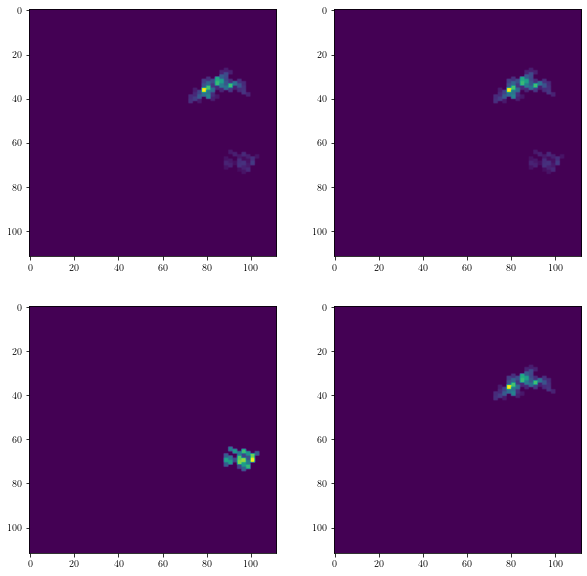

In [51]:
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(test_mixup[1900]))
plt.subplot(222)
plt.imshow(np.squeeze(test_mixup[1900]))
plt.subplot(223)
plt.imshow(np.squeeze(test_mixup[idx1]))
plt.subplot(224)
plt.imshow(np.squeeze(test_mixup[idx2]))

In [16]:
imgs_MST_MONO_Fe[0].shape

(112, 112, 1)

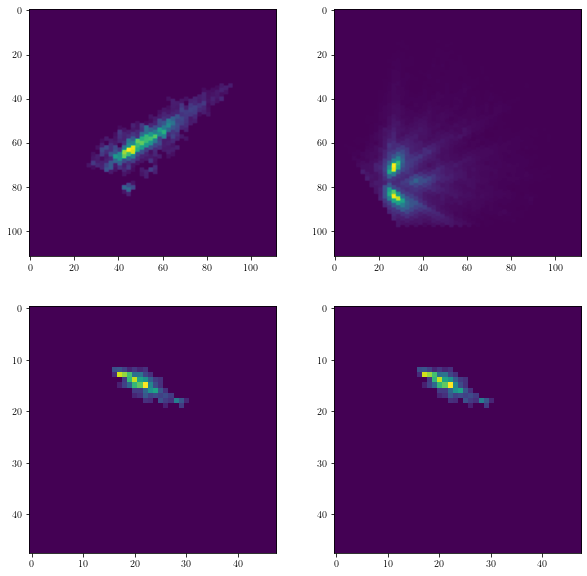

In [8]:
nx = 0
imag1 = imgs_MST_MONO_Fe
imag2 = imgs_MST_STER_Fe
imag3 = imgs_SST_MONO_Fe
imag4 = imgs_SST_STER_Fe

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(imag1[nx]))
plt.subplot(222)
plt.imshow(np.squeeze(imag2[nx]))
plt.subplot(223)
plt.imshow(np.squeeze(imag3[nx]))
plt.subplot(224)
plt.imshow(np.squeeze(imag3[nx]))
# show the plot
plt.show()

In [ ]:
nx = 0
imag1 = median_filter(imgs_MST_MONO_Fe,3)
#imag2 = enhance_edges(imgs_MST_STER_Fe)
#imag3 = enhance_edges(imgs_SST_MONO_Fe)
#imag4 = enhance_edges(imgs_SST_STER_Fe)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(imag1[nx]))
plt.subplot(222)
plt.imshow(np.squeeze(imag2[nx]))
plt.subplot(223)
plt.imshow(np.squeeze(imag3[nx]))
plt.subplot(224)
plt.imshow(np.squeeze(imag4[nx]))
# show the plot
plt.show()

In [ ]:
im = imag2[nx]
sx = sp.ndimage.sobel(im, axis=0, mode='constant')
sy = sp.ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.figure(figsize=(16, 5))
plt.subplot(141)
plt.imshow(im)
plt.axis('off')
plt.title('square', fontsize=20)
plt.subplot(142)
plt.imshow(sx)
plt.axis('off')
plt.title('Sobel (x direction)', fontsize=20)
plt.subplot(143)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel filter', fontsize=20)

im += 0.07*np.random.random(im.shape)

sx = sp.ndimage.sobel(im, axis=0, mode='constant')
sy = sp.ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.subplot(144)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel for noisy image', fontsize=20)



plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=0.9)

plt.show()


In [ ]:
nx = 10
imag1 = imgs_MST_MONO_p
imag2 = imgs_MST_STER_p
imag3 = imgs_SST_MONO_p
imag4 = imgs_SST_STER_p

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.squeeze(imag1[nx]))
plt.subplot(222)
plt.imshow(np.squeeze(imag2[nx]))
plt.subplot(223)
plt.imshow(np.squeeze(imag3[nx]))
plt.subplot(224)
plt.imshow(np.squeeze(imag3[nx]))
# show the plot
plt.show()

# ENERGY, XMAX

In [8]:
# XMAX by species
E_MST_Fe = data_MST['ENERGY'][0]
E_MST_p  = data_MST['ENERGY'][1]
XMAX_MST_Fe = data_MST['XMAX'][0]
XMAX_MST_p  = data_MST['XMAX'][1]

E_SST_Fe = data_SST['ENERGY'][0]
E_SST_p  = data_SST['ENERGY'][1]
XMAX_SST_Fe = data_SST['XMAX'][0]
XMAX_SST_p  = data_SST['XMAX'][1]

#p+Fe
E_MST_Fe_p = np.concatenate((E_MST_Fe,E_MST_p), axis=0)
E_SST_Fe_p = np.concatenate((E_SST_Fe,E_SST_p), axis=0)
XMAX_MST_Fe_p = np.concatenate((E_MST_Fe,E_MST_p), axis=0)
XMAX_SST_Fe_p = np.concatenate((E_SST_Fe,E_SST_p), axis=0)

In [ ]:
plt.hist2d(E_SST_Fe,XMAX_SST_Fe,bins=100)
plt.show()

In [ ]:
nbins= np.arange(0,320,20)
plt.hist(E_SST_Fe,bins=nbins,histtype='step',label='Fe')
plt.hist(E_SST_p,bins=nbins,histtype='step',label='p')
plt.legend(loc='best')
plt.xlabel(r'$E$ (GeV)',size=14)
plt.title('SST',size=14)
plt.yscale('log')
plt.savefig('../figures/E_Fe_P_SST.pdf')
plt.show()

In [ ]:
plt.hist(E_MST_Fe,bins=nbins,histtype='step',label='Fe')
plt.hist(E_MST_p,bins=nbins,histtype='step',label='p')
plt.legend(loc='best')
plt.xlabel(r'$E$ (GeV)',size=14)
plt.title('MST',size=14)
plt.yscale('log')
plt.savefig('../figures/E_Fe_P_MST.pdf')
plt.show()

# DEEP CONVOLUTIONAL NEURAL NET

In [57]:
def DCNN(dim_img,dense_dim,isVar,input_cVar,dp,n_ft,n_conv):
    
    # Define input layer
    patch_x,patch_y = dim_img
    input_image = Input(shape=(patch_x,patch_y,1), name='input_image')
    
    x0 = Conv2D(n_ft, activation='relu', kernel_size=(3, 3),padding='same')(input_image)
    x0 = MaxPooling2D(pool_size=(2, 2))(x0)
    
    for k in range(n_conv):
        fac = int(2*(k+1))
        x0 = Conv2D(int(n_ft), activation='relu', kernel_size=(3, 3),padding='same')(x0)
        #x0 = BatchNormalization()(x0)
        x0 = MaxPooling2D(pool_size=(2, 2))(x0)

    x1 = Flatten()(x0)
    #if isVar:
        # Concatenate Energy
        #input_cVar = Input(shape=(1,), name='cVar')
        #xc = Dense(1, name='concat')(input_cVar)
        #x1 = Concatenate()([x1, input_cVar])
        #x1 = Flatten()(x1)
        
    #x1 = Dropout(dp)(x1)
    x1 = Dense(int(dense_dim*2), activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(x1)
    #x1 = Dropout(dp)(x1)
    x1 = Dense(int(dense_dim), activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(x1)
    x1 = Dropout(dp)(x1)
    xo = Dense(1)(x1)
    
    model = Model(inputs=input_image, outputs=xo)
    
    return model

# SETTING THE PARAMETERS

In [55]:
# PARTICLE AND CASE
part = 'p+Fe'
caso = 'SST-MONO-'

# Setting the Hyperparameters
## CNN Parameters 
# Drop out
dp = 0.2
# Number of Filters
n_ft = 24
# Number of Conv Layers
n_conv = 4
# Dimension of the Latent Space
latent_dim = 40
# L2 regularization
L2_reg= 0
# Learning Rate
lr = 1e-3
# Epochs
epochs = 200
# batch size
batch_size = 64

# VAE-Loss
reco_loss = 'binary'

# augmentation/transfromation of images
isAug = True
isFlip= False
isEdge= False
aug_size = 3000

# auxiliary variable
isVar = False
aux_file = '../data/image_features_SST_MONO_Fe_p.csv'
yX = aux_features(aux_file)[:,:-2]
n_aux = yX.shape[1]
print(n_aux)

6


# TRAIN/TEST SPLIT

In [14]:
dim_r = 1

if part=='p':
    caso = caso+part
    fold = 'Energy/Proton/'
elif part=='Fe':
    caso = caso+part
    
    fold = 'Energy/Iron/'
elif part=='p+Fe':
    caso = caso+part
    fold = 'Energy/Iron+Proton/'

if caso=='SST-MONO-Fe':
    leg = r'Iron, $48\times 48$, Mono'
    data_images = normalize_img(imgs_SST_MONO_Fe)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-STER-Fe':
    leg = r'Iron, $48\times 48$, Stereo'
    data_images = normalize_img(imgs_SST_STER_Fe)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-MONO-Fe':
    leg = r'Iron, $112\times 112$, Mono'
    data_images = normalize_img(imgs_MST_MONO_Fe)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_Fe)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-STER-Fe':
    leg = r'Iron, $112\times 112$, Stereo'
    data_images = normalize_img(imgs_MST_STER_Fe)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_Fe)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-MONO-p':
    leg = r'Proton, $48\times 48$, Mono'
    data_images = normalize_img(imgs_SST_MONO_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_p)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-STER-p':
    leg = r'Proton, $48\times 48$, Stereo'
    data_images = normalize_img(imgs_SST_STER_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_p)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-MONO-p':
    leg = r'Proton, $112\times 112$, Mono'
    data_images = normalize_img(imgs_MST_MONO_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_p)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-STER-p':
    leg = r'Proton, $112\times 112$, Stereo'
    data_images = normalize_img(imgs_MST_STER_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_p)  
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-MONO-p+Fe':
    leg = r'Iron+Proton, $48\times 48$, Mono'
    data_images = normalize_img(imgs_SST_MONO_Fe_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe_p)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-STER-p+Fe':
    leg = r'Iron+Proton, $48\times 48$, Stereo'
    data_images = normalize_img(imgs_SST_STER_Fe_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe_p)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-MONO-p+Fe':
    leg = r'Iron+Proton, $112\times 112$, Mono'
    data_images = normalize_img(imgs_MST_MONO_Fe_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_Fe_p)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='MST-STER-p+Fe':
    leg = r'Iron+Proton, $112\times 112$, Stereo'
    data_images = normalize_img(imgs_MST_STER_Fe_p)
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_MST_Fe_p)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax

print(caso, dim_img, dim_r)
fake = np.zeros((data_images.shape[0]))
pred = np.zeros((yE.shape))

SST-MONO-p+Fe [48, 48] 1


In [12]:
def conv(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [43]:
# Train/Test split
rs = 42
if isEdge:
    #data_images = median_filter(data_images,2)
    data_images = enhance_edges(data_images)
    
train_data, test_data, train_e, test_e = train_test_split(data_images,yE,test_size=0.33,shuffle=True,random_state=rs)
_, _, train_xmax, test_xmax = train_test_split(data_images,yX,test_size=0.33,shuffle=True,random_state=rs)
train_xmax = conv(train_xmax)
input_cVar = conv(train_xmax)

# augment data
if isAug:
    caso = caso+'-aug'
    #train_data_aug, train_e_aug = augment_by_transformation(train_data,train_e,augment_size,isFlip,1)
    train_data_aug, train_e_aug = augment_mixup(train_data,train_e,aug_size,1)
    train_e_aug = conv(train_e_aug)
    input_cVar = conv(train_e_aug)
    if isVar:
        caso = caso+'-xmax'
        _, train_xmax_aug = augment_mixup(train_data,train_xmax,aug_size,n_aux)
        train_xmax_aug = conv(train_xmax_aug)
        input_cVar = conv(train_xmax_aug)

# auxiliary variable
if not isAug and isVar:
    caso = caso+'-xmax'
    _, _, train_xmax, test_xmax = train_test_split(data_images,yX,test_size=0.2,shuffle=True,random_state=rs)
    train_xmax = conv(train_xmax)
    input_cVar = conv(train_xmax)

In [63]:
print(train_data.shape,train_data_aug.shape)
print(train_e_aug.shape)

(2546, 48, 48, 1) (5546, 48, 48, 1)
(5546,)


In [58]:
## Train the network
#for train_idx, test_idx in skf.split(data_images, fake):
    
    #print(train_idx)
    
#    train_data = data_images[train_idx]
#    train_e = np.log(yE[train_idx])

#    test_data = data_images[test_idx]
#    test_e = np.log(yE[test_idx])

checkpoint_filepath = '../models/'+fold+'e_best_weights_dcnn_'+caso+'.h5' 
model_checkpoint_callback = ModelCheckpoint(
                    filepath=checkpoint_filepath,
                    save_weights_only=True,
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True)

# instantiate the model
model = DCNN(dim_img,latent_dim,isVar,input_cVar,dp,n_ft,n_conv)

######################################
#step = tf.Variable(0, trainable=False)
#schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#    [200, 400, 600, 800], [1.0, 0.5, 0.25, 0.125, 0.0625])
# lr and wd can be a function or a tensor
#lr = 1e-3 #* schedule(step)
#wd = lambda: 1e-2 * schedule(step)
#loss_fn = mse
opt = Adam(learning_rate=lr) #'adam'
#opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
reduce_lr = ReduceLROnPlateau(monitor='lr', factor=0.5,
                              patience=20, min_lr=1e-8)



########## Early stopping
stop = EarlyStopping(monitor='val_loss', mode='min', patience=25)

######################################
# Compilatio
model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mse'])
model.summary()
#vae.save_weights('../models/vae_dnn_weights.hdf5')

if isAug:
    train_x = train_data_aug
    train_y = train_e_aug
else:
    train_x = train_data
    train_y = train_e
    
history=model.fit(train_x,train_y,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[model_checkpoint_callback, reduce_lr, stop], #,TensorBoard(log_dir='/tmp/autoencoder')],
                validation_split = 0.25,
                #validation_data=([X_valid, Y_valid]),
                verbose = 1)

model.save_weights('../models/'+fold+'e_dcnn_weights_'+caso+'.h5')

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 48, 48, 24)        240       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 24, 24, 24)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 24, 24, 24)        5208      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 12, 12, 24)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 12, 12, 24)        5208      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 6, 6, 24)          0   

Epoch 36/200
65/65 [==============================] - 3s 51ms/step - loss: 1.0288 - mae: 0.8047 - mse: 1.0288 - val_loss: 1.0062 - val_mae: 0.7821 - val_mse: 1.0062
Epoch 37/200
65/65 [==============================] - 3s 50ms/step - loss: 1.0124 - mae: 0.7889 - mse: 1.0124 - val_loss: 1.0726 - val_mae: 0.8043 - val_mse: 1.0726
Epoch 38/200
65/65 [==============================] - 3s 49ms/step - loss: 0.9928 - mae: 0.7805 - mse: 0.9928 - val_loss: 1.0015 - val_mae: 0.7748 - val_mse: 1.0015
Epoch 39/200
65/65 [==============================] - 3s 50ms/step - loss: 1.0226 - mae: 0.7977 - mse: 1.0226 - val_loss: 1.0306 - val_mae: 0.7846 - val_mse: 1.0306
Epoch 40/200
65/65 [==============================] - 3s 54ms/step - loss: 0.9869 - mae: 0.7783 - mse: 0.9869 - val_loss: 1.0140 - val_mae: 0.7788 - val_mse: 1.0140
Epoch 41/200
65/65 [==============================] - 3s 49ms/step - loss: 0.9933 - mae: 0.7764 - mse: 0.9933 - val_loss: 1.0040 - val_mae: 0.7733 - val_mse: 1.0040
Epoch 42/2

Epoch 86/200
65/65 [==============================] - 3s 47ms/step - loss: 0.7719 - mae: 0.6684 - mse: 0.7719 - val_loss: 0.8979 - val_mae: 0.7144 - val_mse: 0.8979
Epoch 87/200
65/65 [==============================] - 3s 47ms/step - loss: 0.7771 - mae: 0.6715 - mse: 0.7771 - val_loss: 0.9013 - val_mae: 0.7167 - val_mse: 0.9013
Epoch 88/200
65/65 [==============================] - 3s 45ms/step - loss: 0.7737 - mae: 0.6680 - mse: 0.7737 - val_loss: 0.8987 - val_mae: 0.7133 - val_mse: 0.8987
Epoch 89/200
65/65 [==============================] - 3s 46ms/step - loss: 0.7672 - mae: 0.6661 - mse: 0.7672 - val_loss: 0.9041 - val_mae: 0.7171 - val_mse: 0.9041
Epoch 90/200
65/65 [==============================] - 3s 46ms/step - loss: 0.7806 - mae: 0.6734 - mse: 0.7806 - val_loss: 0.9047 - val_mae: 0.7198 - val_mse: 0.9047
Epoch 91/200
65/65 [==============================] - 3s 47ms/step - loss: 0.7642 - mae: 0.6648 - mse: 0.7642 - val_loss: 0.9018 - val_mae: 0.7142 - val_mse: 0.9018
Epoch 92/2

65/65 [==============================] - 3s 49ms/step - loss: 0.7368 - mae: 0.6480 - mse: 0.7368 - val_loss: 0.8874 - val_mae: 0.7060 - val_mse: 0.8874
Epoch 185/200
65/65 [==============================] - 3s 50ms/step - loss: 0.7397 - mae: 0.6503 - mse: 0.7397 - val_loss: 0.8827 - val_mae: 0.7035 - val_mse: 0.8827
Epoch 186/200
65/65 [==============================] - 3s 50ms/step - loss: 0.7253 - mae: 0.6446 - mse: 0.7253 - val_loss: 0.8849 - val_mae: 0.7047 - val_mse: 0.8849
Epoch 187/200
65/65 [==============================] - 3s 48ms/step - loss: 0.7313 - mae: 0.6501 - mse: 0.7313 - val_loss: 0.8859 - val_mae: 0.7052 - val_mse: 0.8859
Epoch 188/200
65/65 [==============================] - 3s 48ms/step - loss: 0.7362 - mae: 0.6515 - mse: 0.7362 - val_loss: 0.8853 - val_mae: 0.7049 - val_mse: 0.8853
Epoch 189/200
65/65 [==============================] - 3s 48ms/step - loss: 0.7275 - mae: 0.6473 - mse: 0.7275 - val_loss: 0.8854 - val_mae: 0.7050 - val_mse: 0.8854
Epoch 190/200
65/6

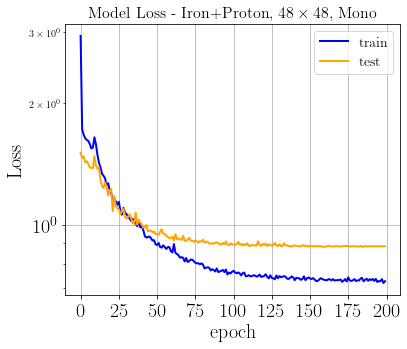

In [59]:
plt.figure(figsize=(6,5))
plt.plot(history.history['loss'], lw=2, color='blue')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.title('Model Loss - '+leg,size=16)
plt.ylabel('Loss',size=20)
plt.xlabel('epoch',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid(True)
plt.yscale('log')
plt.legend(['train','test'], loc='best')
plt.rc('legend',fontsize=14) 
#plt.savefig('../figures/'+fold+'e_loss_vae_'+caso+'.pdf')
plt.show()

In [60]:
model.load_weights('../models/'+fold+'e_best_weights_dcnn_'+caso+'.h5')
model.compile(optimizer=opt)

#encoder.load_weights('../models/'+fold+'e_encoder_weights_'+caso+'.h5')
#encoder.compile(optimizer=opt)

# testing
y_pred = model.predict(test_data,batch_size=batch_size)[:,0]

rMSE_test = np.sqrt(mean_squared_error(test_e,y_pred))
R2_test = r2_score(test_e, y_pred)
## CC accuracy

print("rMSE: ",rMSE_test)
print("R2: ",R2_test)

rMSE:  1.1617037546837652
R2:  0.1897221804232857


In [ ]:
# chi squared
def chi2(a,b):
    return np.sum((a-b)**2/a)

In [ ]:
for dbin in range(200,20,-20):
    nbins = np.arange(0,300+dbin,dbin)
    a,_ = np.histogram(np.exp(test_e),bins=nbins)
    b,_ = np.histogram(np.exp(ypred),bins=nbins)
    x2pdof = chi2(a,b)/len(a)
    print(dbin,x2pdof)

In [ ]:
dbin=60
nbins = np.arange(0,300+dbin,dbin)
a,_ = np.histogram(np.exp(test_e),bins=nbins)
b,_ = np.histogram(np.exp(ypred),bins=nbins)
x2pdof = chi2(a,b)/len(a)

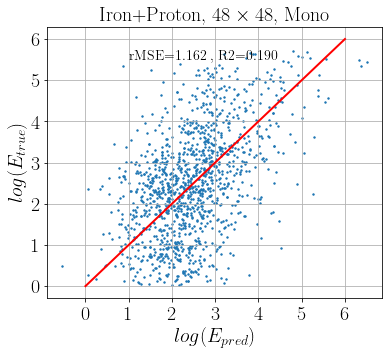

In [61]:
plt.figure(figsize=(6,5))
plt.scatter(y_pred, test_e, s=2)
plt.plot([0,6],[0,6],lw=2,color='red')
#plt.xlim([0,11])
#plt.ylim([0,11])
plt.grid(True)
plt.xlabel(r'$log(E_{pred})$',size=20)
plt.ylabel(r'$log(E_{true})$',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.text(1,5.5,"rMSE=%.3f , R2=%.3f"%(rMSE_test,R2_test),size=14)
plt.title(leg,size=20)
#plt.savefig('../figures/'+fold+'e_true_pred_vae_'+caso+'.pdf')
plt.show()

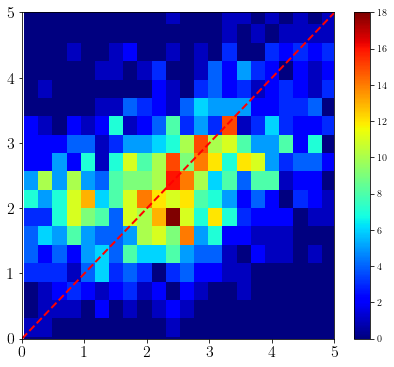

In [62]:
plt.figure(figsize=(7,6))
plt.hist2d(test_e,y_pred, bins=(25,25), cmap=plt.cm.jet)
plt.plot([0,5],[0,5],lw=2,color='red',linestyle='--')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xticks(size=16)
plt.yticks(size=16)
plt.colorbar()
plt.show()

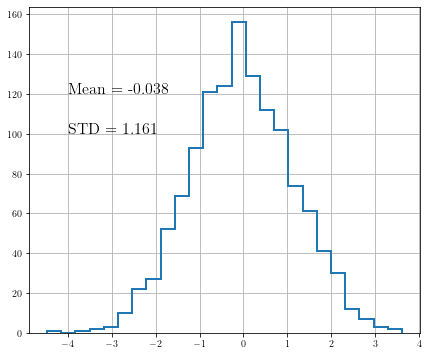

In [63]:
diff = y_pred-test_e
mdiff, sdiff = np.mean(diff), np.std(diff)
plt.figure(figsize=(7,6))
plt.hist(diff,bins=25,lw=2,histtype='step')
plt.text(-4,120, r'Mean = %.3f'%(mdiff),size=16)
plt.text(-4,100, r'STD = %.3f'%(sdiff),size=16)
plt.grid(True)
plt.show()

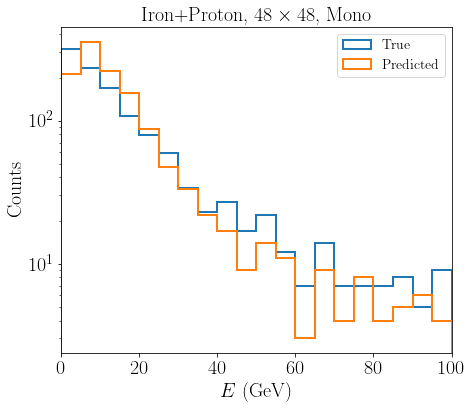

In [64]:
nbins = np.arange(0,105,5)

plt.figure(figsize=(7,6))
plt.hist(np.exp(test_e),bins=nbins,lw=2,histtype='step',label='True')
plt.hist(np.exp(y_pred),bins=nbins,lw=2,histtype='step',label='Predicted')
plt.xlabel(r'$E$ (GeV)',size=20)
plt.ylabel(r'Counts',size=20)
plt.xticks(size=20)
plt.yticks(size=20)

plt.legend(loc='best')
plt.xlim([0,100])
#plt.text(120,30,r"$\chi^2$/dof = %.3f"%(x2pdof),size=20)
plt.title(leg,size=20)
plt.yscale('log')
#plt.savefig('../figures/'+fold+'e_vae_'+caso+'.pdf')
plt.show()